<a href="https://colab.research.google.com/github/vtu22710-oi/data-visualization/blob/main/Usecase_Manufacturing_%E2%80%93_Production_Line_Efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Starting Manufacturing Data Analysis ---
Loading data from /content/hybrid_manufacturing_categorical.csv...
Data processing complete.

--- CO1: Process Data Sample ---
  Job_ID Machine_ID Operation_Type  Efficiency_Percentage  \
0   J001        M01       Grinding                     96   
1   J002        M01       Grinding                     84   
2   J003        M04       Additive                     92   
3   J004        M04       Grinding                     95   
4   J005        M01          Lathe                     88   

   Start_Delay_Minutes  Actual_Processing_Minutes  
0                  5.0                       76.0  
1                 10.0                       79.0  
2                  0.0                        0.0  
3                  5.0                      106.0  
4                  2.0                       46.0  
--------------------------------

Generating CO2: Performance Analysis Plots...


/tmp/ipython-input-1306002538.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Start_Delay_Minutes'].fillna(0, inplace=True)
/tmp/ipython-input-1306002538.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Saved co2_histograms.png
Saved co2_efficiency_over_time.png
Generating CO3: Machine-Operation Dependency Network...
Saved co3_dependency_network.png
Generating CO4: Mock Factory Layout Plot...


/tmp/ipython-input-1306002538.py:173: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  zone_colors = plt.cm.get_cmap('tab20', len(zones))


Saved co4_mock_layout.png
Preparing CO5: Data for Power BI...
Successfully saved data to 'factory_performance_for_dashboard.csv'.

--- NEXT STEP FOR CO5 ---
Import 'factory_performance_for_dashboard.csv' into Power BI Desktop.
You can now build your dashboard using these fields:
- Track 'Efficiency_Percentage' by 'Machine_ID'.
- Analyze 'Start_Delay_Minutes' by 'Operation_Type'.
- Create a timeline of 'Job_Status' using 'Actual_Start' date.
---------------------------

--- Analysis Complete ---
All plots and data files have been saved to the script's directory.
You can now view the .png files and use the .csv file in Power BI.


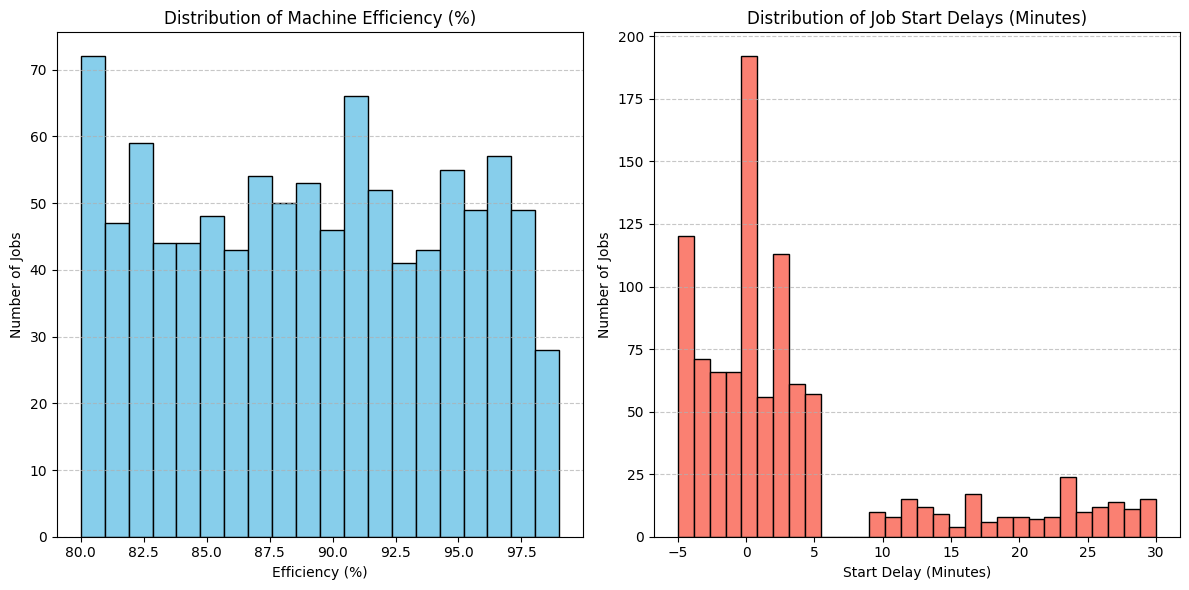

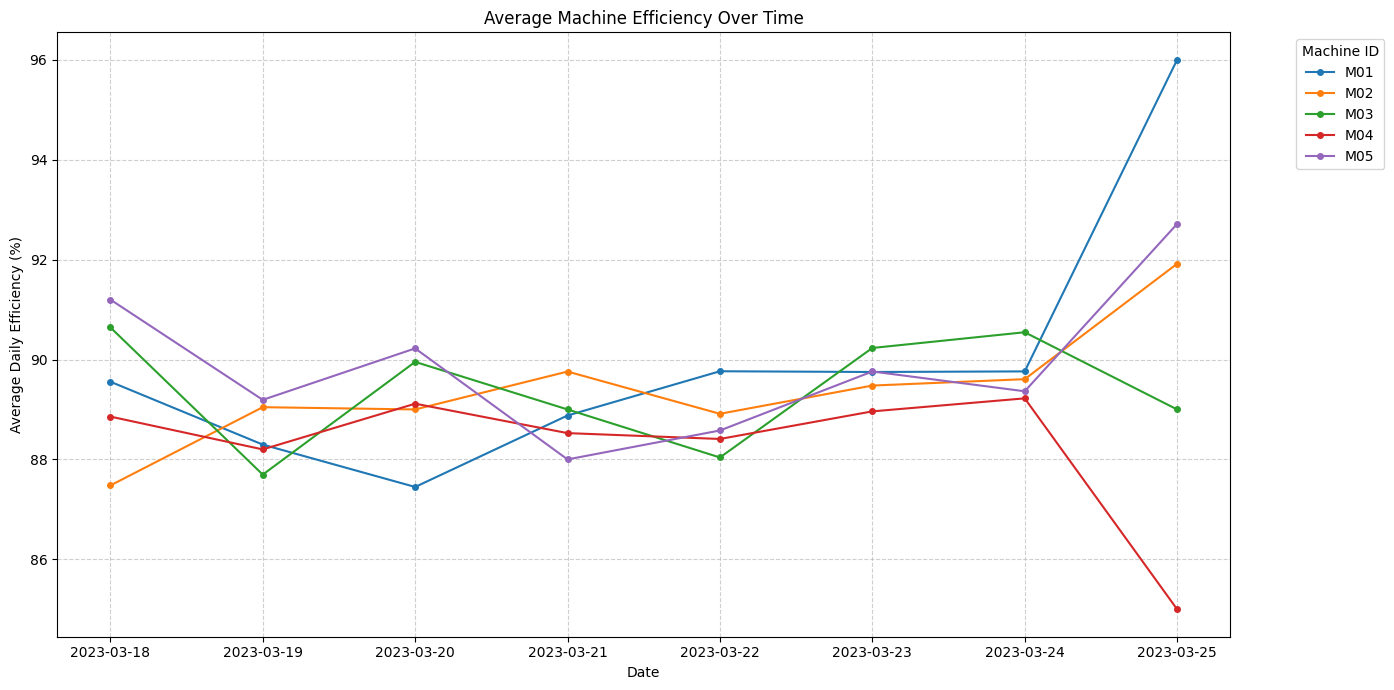

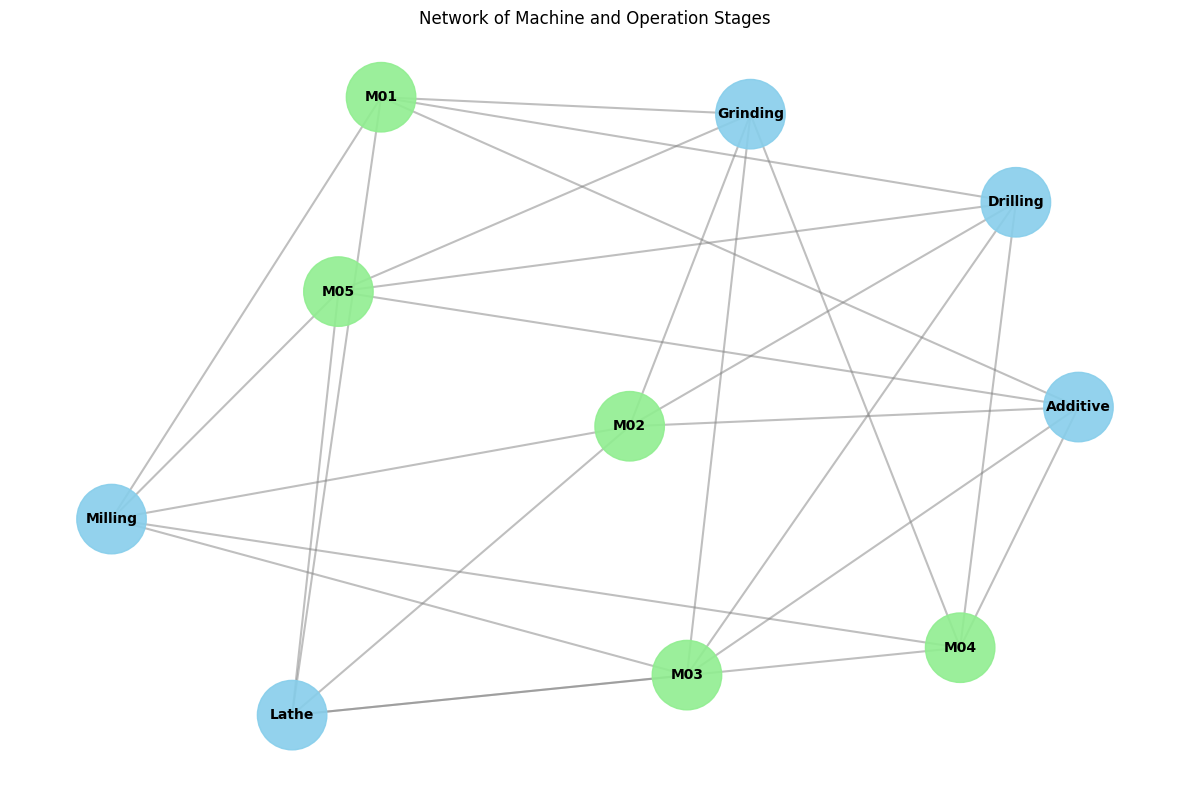

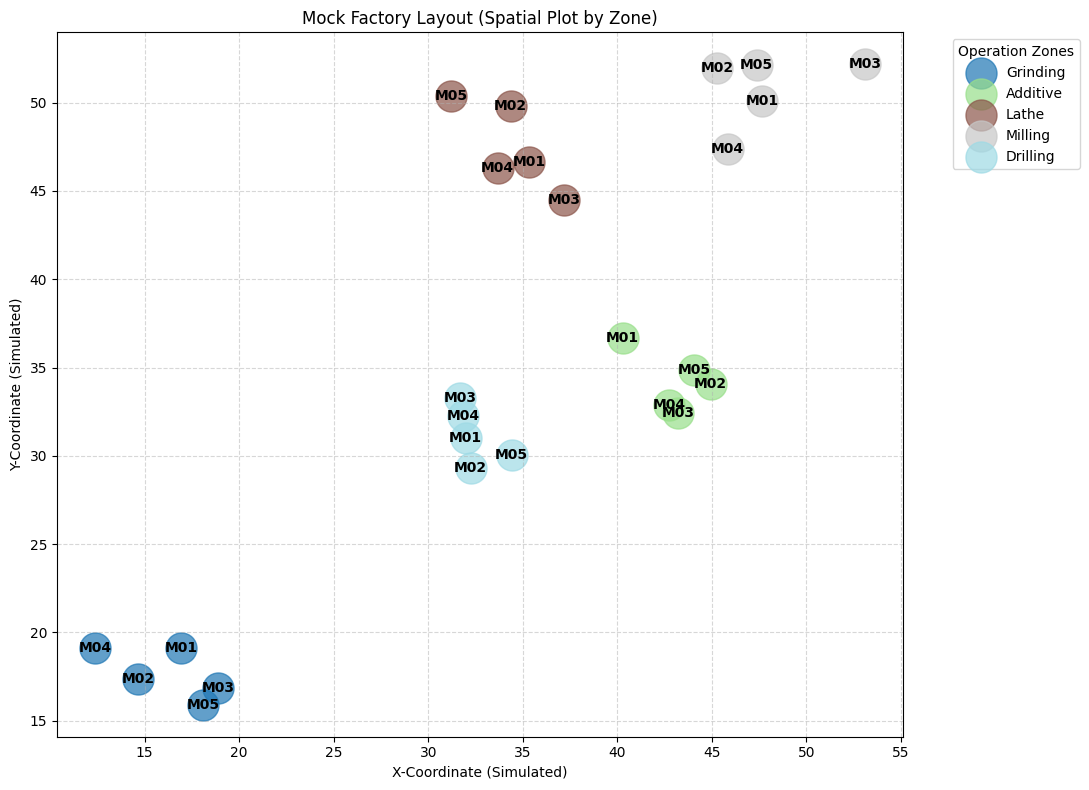

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
from datetime import datetime

# --- Configuration ---
FILE_PATH = '/content/hybrid_manufacturing_categorical.csv'
OUTPUT_DASHBOARD_FILE = 'factory_performance_for_dashboard.csv'

def load_and_process_data(filepath):
    """
    Loads and processes the manufacturing data.
    - Loads the CSV
    - Converts date columns
    - Calculates new metrics like delays and processing times.
    """
    print(f"Loading data from {filepath}...")
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        print("Please make sure 'hybrid_manufacturing_categorical.csv' is in the same directory as the script.")
        return None

    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

    # Convert timestamp columns to datetime objects, handling potential errors
    date_cols = ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce') # 'coerce' turns bad dates into NaT (Not a Time)

    # --- CO1: Identify and Calculate Process Data ---

    # Rename 'Machine_Availability' to 'Efficiency' for clarity
    df.rename(columns={'Machine_Availability': 'Efficiency_Percentage'}, inplace=True)

    # Calculate 'Start_Delay_Minutes' (a proxy for downtime or waiting time)
    # This is the difference between when a job was scheduled to start and when it actually did
    df['Start_Delay_Minutes'] = (df['Actual_Start'] - df['Scheduled_Start']).dt.total_seconds() / 60

    # Calculate 'Actual_Processing_Minutes'
    df['Actual_Processing_Minutes'] = (df['Actual_End'] - df['Actual_Start']).dt.total_seconds() / 60

    # Handle cases where delay might be negative (started early) or NaT (e.g., failed jobs)
    # Fill NaN delays with 0 for aggregation, though they could be filtered
    df['Start_Delay_Minutes'].fillna(0, inplace=True)
    df['Actual_Processing_Minutes'].fillna(0, inplace=True)

    print("Data processing complete.")
    return df

def analyze_performance_plots(df):
    """
    CO2: Use line plots and histograms for performance analysis.
    """
    print("Generating CO2: Performance Analysis Plots...")

    # --- Histogram 1: Machine Efficiency Distribution ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df['Efficiency_Percentage'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Machine Efficiency (%)')
    plt.xlabel('Efficiency (%)')
    plt.ylabel('Number of Jobs')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Histogram 2: Start Delay Distribution ---
    # We'll filter out extreme outliers for a more readable histogram
    reasonable_delays = df[df['Start_Delay_Minutes'].between(-60, 240)] # -1hr to +4hrs
    plt.subplot(1, 2, 2)
    plt.hist(reasonable_delays['Start_Delay_Minutes'], bins=30, color='salmon', edgecolor='black')
    plt.title('Distribution of Job Start Delays (Minutes)')
    plt.xlabel('Start Delay (Minutes)')
    plt.ylabel('Number of Jobs')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('co2_histograms.png')
    print("Saved co2_histograms.png")

    # --- Line Plot: Average Efficiency Over Time by Machine ---
    plt.figure(figsize=(14, 7))

    # We need a datetime index to resample
    df_time_indexed = df.set_index('Actual_Start').sort_index()

    # Group by Machine_ID and resample by Day, calculating mean efficiency
    for machine_id, group_data in df_time_indexed.groupby('Machine_ID'):
        # Resample data by day ('D') and calculate the mean. Use .dropna() to avoid plotting empty days
        daily_efficiency = group_data['Efficiency_Percentage'].resample('D').mean().dropna()
        if not daily_efficiency.empty:
            plt.plot(daily_efficiency.index, daily_efficiency, marker='o', linestyle='-', markersize=4, label=machine_id)

    plt.title('Average Machine Efficiency Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Daily Efficiency (%)')
    plt.legend(title='Machine ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('co2_efficiency_over_time.png')
    print("Saved co2_efficiency_over_time.png")

def visualize_machine_dependency(df):
    """
    CO3: Construct a network showing dependency among machines/stages.
    This creates a bipartite graph showing which 'Operation_Type' (stage)
    is performed by which 'Machine_ID'.
    """
    print("Generating CO3: Machine-Operation Dependency Network...")

    # Find unique relationships between machines and operations
    links = df[['Machine_ID', 'Operation_Type']].drop_duplicates()

    if links.empty:
        print("No machine-operation links found to build a network.")
        return

    G = nx.Graph()
    operations = links['Operation_Type'].unique()
    machines = links['Machine_ID'].unique()

    # Add nodes to the graph, classifying them by type (bipartite)
    G.add_nodes_from(operations, bipartite=0, type_label='Operation')
    G.add_nodes_from(machines, bipartite=1, type_label='Machine')

    # Add edges from the links
    G.add_edges_from(links.values)

    # Prepare for plotting
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.7, seed=42) # 'k' adjusts spring length

    # Draw nodes
    colors = ['skyblue' if G.nodes[n]['bipartite'] == 0 else 'lightgreen' for n in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=2500, alpha=0.9)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    plt.title('Network of Machine and Operation Stages')
    plt.axis('off') # Hide the axes
    plt.tight_layout()
    plt.savefig('co3_dependency_network.png')
    print("Saved co3_dependency_network.png")

def visualize_mock_factory_layout(df):
    """
    CO4: Visualize factory layout using spatial plots (machine zones).
    NOTE: The dataset does not contain X, Y coordinates.
    This function creates a *MOCK* layout by grouping machines
    into zones based on their 'Operation_Type'.
    """
    print("Generating CO4: Mock Factory Layout Plot...")

    # Get unique machines and their primary operation
    # (Simplified: assumes one operation per machine for layout)
    machine_zones = df[['Machine_ID', 'Operation_Type']].drop_duplicates().set_index('Machine_ID')

    if machine_zones.empty:
        print("No machine-zone data found to plot.")
        return

    zones = machine_zones['Operation_Type'].unique()

    # Create a color map for zones
    zone_colors = plt.cm.get_cmap('tab20', len(zones))
    color_map = {zone: zone_colors(i) for i, zone in enumerate(zones)}

    # Create mock coordinates for zones
    zone_coords = {zone: (np.random.rand() * 50, np.random.rand() * 50) for i, zone in enumerate(zones)}

    plt.figure(figsize=(11, 8))

    # Plot each machine
    for machine_id, row in machine_zones.iterrows():
        zone = row['Operation_Type']
        base_x, base_y = zone_coords[zone]

        # Add small random offset so machines in the same zone don't overlap perfectly
        plot_x = base_x + np.random.randn() * 2
        plot_y = base_y + np.random.randn() * 2

        plt.scatter(plot_x, plot_y, color=color_map[zone], s=500, alpha=0.7, label=zone if machine_id == machine_zones[machine_zones['Operation_Type'] == zone].index[0] else "")
        plt.text(plot_x, plot_y, machine_id, ha='center', va='center', fontsize=10, weight='bold')

    plt.title('Mock Factory Layout (Spatial Plot by Zone)')
    plt.xlabel('X-Coordinate (Simulated)')
    plt.ylabel('Y-Coordinate (Simulated)')

    # Create a legend with unique entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Operation Zones', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('co4_mock_layout.png')
    print("Saved co4_mock_layout.png")

def prepare_for_power_bi(df):
    """
    CO5: Prepare data for a Power BI dashboard.
    This function selects key columns and saves them to a new CSV.
    """
    print(f"Preparing CO5: Data for Power BI...")

    dashboard_cols = [
        'Job_ID',
        'Machine_ID',
        'Operation_Type',
        'Material_Used',
        'Energy_Consumption',
        'Efficiency_Percentage',
        'Scheduled_Start',
        'Scheduled_End',
        'Actual_Start',
        'Actual_End',
        'Job_Status',
        'Optimization_Category',
        'Start_Delay_Minutes',
        'Actual_Processing_Minutes'
    ]

    # Filter for columns that actually exist in the dataframe
    final_cols = [col for col in dashboard_cols if col in df.columns]

    dashboard_df = df[final_cols]

    try:
        dashboard_df.to_csv(OUTPUT_DASHBOARD_FILE, index=False)
        print(f"Successfully saved data to '{OUTPUT_DASHBOARD_FILE}'.")
        print("\n--- NEXT STEP FOR CO5 ---")
        print(f"Import '{OUTPUT_DASHBOARD_FILE}' into Power BI Desktop.")
        print("You can now build your dashboard using these fields:")
        print("- Track 'Efficiency_Percentage' by 'Machine_ID'.")
        print("- Analyze 'Start_Delay_Minutes' by 'Operation_Type'.")
        print("- Create a timeline of 'Job_Status' using 'Actual_Start' date.")
        print("---------------------------\n")
    except Exception as e:
        print(f"Error saving file for Power BI: {e}")

def main():
    """
    Main function to run the complete analysis pipeline.
    """
    print("--- Starting Manufacturing Data Analysis ---")

    # Load and process data (CO1)
    df = load_and_process_data(FILE_PATH)

    if df is None:
        print("Failed to load or process data. Exiting.")
        return

    # Print summary for CO1
    print("\n--- CO1: Process Data Sample ---")
    print(df[['Job_ID', 'Machine_ID', 'Operation_Type', 'Efficiency_Percentage', 'Start_Delay_Minutes', 'Actual_Processing_Minutes']].head())
    print("--------------------------------\n")

    # Generate plots for CO2
    analyze_performance_plots(df)

    # Generate network for CO3
    visualize_machine_dependency(df)

    # Generate mock layout for CO4
    visualize_mock_factory_layout(df)

    # Prepare data for CO5
    prepare_for_power_bi(df)

    print("--- Analysis Complete ---")
    print("All plots and data files have been saved to the script's directory.")
    print("You can now view the .png files and use the .csv file in Power BI.")
    # plt.show() # Uncomment this line if you want plots to display automatically when running the script


if __name__ == "__main__":
    main()
